<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели каритнку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всегоработают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/HR_cHsJcbMpL-g)

### Базовая часть:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:
Что еще можно сделать:
1. Нагуглить другой датасет (в MSCOCO видны паттерны -- все тексты выглядят как "хто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети (не, ну а вдруг)
4. Написать бота ))0))
5. Whatever comes to your head

## Базовая часть:

### 1. Предобработка текстов из датасета

In [1]:
DATA_PATH = ''
%matplotlib inline

# For Google Colab only:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
#from reco_utils.recommender.sar.sar_singlenode import SARSingleNode
from google.colab import drive
drive.mount('/content/gdrive')

DATA_PATH = 'gdrive/My Drive/Colab Notebooks/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import json

# загружаем датасет
img_codes = np.load("/content/gdrive/My Drive/Colab Notebooks/handout/data/image_codes.npy")
captions = json.load(open('/content/gdrive/My Drive/Colab Notebooks/handout/data/captions_tokenized.json'))

In [3]:
img_codes.shape

(118287, 2048)

In [4]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречания каждого слова из словаря и оставить тольео те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлвх занятиях. Батч должен выглядеть примерно так:

[[   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,2,    3,    3,    3,    3,    3,    3,    3],
   
[   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,2,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,393,  525, 4618, 8335, 6292, 7882, 7696,    2]]
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезуются, в начале и конце по коду символа начал и конца предложения.

Уверена, эта часть вам покажется очень знакомой и легкой =)

In [0]:
#<your code, please>
BOS,EOS,UNK,PAD ="BOS", "EOS","UNK","PAD"
from collections import Counter
token_counts = Counter()

for i in range(len(captions)):
    for j in range(len(captions[i])):
        token_counts.update(captions[i][j].split())
        captions[i][j]=BOS+' '+captions[i][j]+' '+EOS

# давайте оставм в словаре только те слова, которые встречаются в нашем датасете не меньше 5 раз.
# просто чтобы уменьшить
min_count = 0  # Если оставить все слова в словаре, кажется описания генерятся лучше.
tokens = [token for token, num in token_counts.items() if num>=min_count]
trash= [token for token, num in token_counts.items() if num<min_count]

# добавим два токена: для неизвестных слов (которых нет в словаре) и паддинг, 
# которым мы будем в батче дополнять короткие предложения

tokens = [BOS,EOS,UNK,PAD] + tokens

In [6]:
tokens[:20]

['BOS',
 'EOS',
 'UNK',
 'PAD',
 'people',
 'shopping',
 'in',
 'an',
 'open',
 'market',
 'for',
 'vegetables',
 '.',
 'full',
 'of',
 'and',
 'piles',
 'are',
 'at',
 'air']

In [7]:
len(tokens)

29415

In [8]:
len(trash)

0

In [0]:
n_tokens=len(tokens)

Сохраним словарь в файл

In [0]:
with open("vocab.txt", "w") as file:
    print(*tokens, file=file)

### 2. Напишем свою сетку из RNN для вывода описаний


Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [0]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        super(self.__class__, self).__init__()
        
        # два линейных слоя, которые будут из векторов, полученных на выходе Inseption, 
        # получать начальные состояния h0 и c0 LSTM-ки, которую мы потом будем 
        # разворачивать во времени и генерить ею текст
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # вот теперь recurrent part

        # create embedding for input words. Use the parameters (e.g. emb_size).
        #self.embedding_layer = nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size, padding_idx=PAD_IX)
        self.embedding_layer = nn.Embedding(n_tokens, emb_size)    
        # lstm: настакайте LSTM-ок (1 или более, но не надо сразу пихать больше двух, замечаетесь ждать).
        #<YOUR CODE>
        self.lstm = nn.LSTM(input_size = emb_size,hidden_size = lstm_units,
                            num_layers = 1, batch_first = True)    
        # ну и линейный слой для получения логитов
        self.linear = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix, device=device):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержаший выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions_ix: 
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # 
        #captions_emb = <YOUR CODE>
        emb = self.embedding_layer(captions_ix)
        # применим LSTM:
        # 1. инициализируем lstm state с помощью initial_* (сверху)
        # 2. скормим LSTM captions_emb
        # 3. посчитаем логиты из выхода LSTM
        
        
        #lstm_out = <YOUR_CODE> # shape: [batch, caption_length, lstm_units]
        lstm_outputs, _ = self.lstm(emb,(initial_cell.unsqueeze(0),initial_hid.unsqueeze(0)))
       
        #logits = <YOUR_CODE> 
        logits = self.linear(lstm_outputs)
        return logits        

In [14]:
network = CaptionNet(n_tokens)
print(network)

CaptionNet(
  (cnn_to_h0): Linear(in_features=2048, out_features=256, bias=True)
  (cnn_to_c0): Linear(in_features=2048, out_features=256, bias=True)
  (embedding_layer): Embedding(29415, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=29415, bias=True)
)


In [0]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor c выходами inception. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor с описаниями (в виде матрицы). shape: [batch, word_i]. 
    
    :returns: scalar crossentropy loss (neg log likelihood) for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # ВАЖНО: не забудтье, что PADDING не должен влиять на лосс -- лосс должен склыдваться
    # только из тех мест, где должно быть предсказано слово, а не PAD
    # это можно сделать либо заведя маску из нулей и единиц (captions_ix_next != pad_ix) и умножить на нее лосс,
    # либо просто используя ignore_index, который в торче есть как аргумент у некоторых лоссов.
    nseqs=logits_for_next.shape[0]
    seq_len=logits_for_next.shape[1]
    #loss = <YOUR CODE>
    loss = criterion(logits_for_next.view(nseqs*seq_len,-1), captions_ix_next.view(nseqs*seq_len)) 
    return loss

In [0]:
optimizer = torch.optim.Adam(params = network.parameters(), lr = 0.001)

Поделим выборку на train/test:

In [0]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [0]:
# словарь токен: индекс
token_to_id = {t:i for i, t in enumerate(tokens)}

In [19]:
UNK_IX, PAD_IX, BOS_IX, EOS_IX = map(token_to_id.get, [UNK, PAD, BOS, EOS]) # получим индексы токенов UNK, PAD
print('UNK_IX=', UNK_IX, 'PAD_IX=', PAD_IX,'BOS_IX=', BOS_IX, 'EOS_IX=', EOS_IX)

def as_matrix(sequences, max_len=None):
    """ 
    Convert a list of tokens into a matrix with padding 
    params:
        sequences: list of sentences. Each sentence is a tokenized string or list of tokens
        indices_not_words  =True  - если возвращается матрица индексов слов из исходного предложения (если используем непредобученный слой nn.Embedding)
                           =False - если возвращается матрица слов из исходного предложения (если используем предобученные Embedding-и)
        max_len: if specified, 
    """
    if isinstance(sequences[0], str): # проверка принадлежности данных определенному классу (типу данных str - в данном случае)
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf')) 
    #print('max_len =', max_len)
    
    # max_len = мин из(максимум из длин предложений в sequences; входной max_len (если он есть) или бесконечное значение (если нет  max_len))
    # т.е. если есть входной max_len, то max_len = мин из(максимум из длин предложений в sequences, входной max_len)
    # если нет входного max_len, то  max_len = максимум из длин предложений в sequences

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX)) # матрица размера: количество входных предложений х max_len (сначала заполняем индексом PAD-а)
    for i,seq in enumerate(sequences): # перенумерованные входные предложения
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]] # row_ix - это массив индексов слов в очередном предложении
        #if i<3: # TTT insert
        #    print('i row_ix:',i,row_ix)   # TTT insert
        matrix[i, :len(row_ix)] = row_ix # i-й строке матрицы (элементам i-й строки от начала до len(row_ix) (:len(row_ix))
                                             # присвоить row_ix (массив индексов слов в очередном предложении)

    #print ('matrix=\r\n',  matrix[0:6]) # выведем строки matrix с 0-й по 5-ю
    return matrix

UNK_IX= 2 PAD_IX= 3 BOS_IX= 0 EOS_IX= 1


In [0]:
# batch generator. Можно заменить на свой/переделать этот
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32).to(device), torch.tensor(batch_captions_ix, dtype=torch.int64).to(device)
    

## Train it

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [0]:
import nltk
import torch, torch.nn as nn
import torch.nn.functional as F
import time
import math
import random

In [0]:
#<your code here>
from tqdm import tnrange
def iterate_minibatches(img_codes, captions, batch_size=32, max_len=None,
                         shuffle=True, verbose=True):
    max_batches=len(img_codes)//batch_size
    indices = np.arange(batch_size * max_batches)
    #indices = indices[: batch_size * max_batches]
    if shuffle:
        indices = np.random.permutation(indices)
    
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(img_codes[indices[start : start + batch_size]],captions[indices[start : start + batch_size]],batch_size, max_caption_len=max_len)

In [0]:
# меняйте параметры как хотите
num_epochs = 5
max_len = 30
batch_size = 64
#batches_per_epoch = 100
lr=0.001

In [24]:
if 'model' in locals(): # ***
    del network
    
network = CaptionNet(n_tokens = len(tokens)).to(device)

print(network)

CaptionNet(
  (cnn_to_h0): Linear(in_features=2048, out_features=256, bias=True)
  (cnn_to_c0): Linear(in_features=2048, out_features=256, bias=True)
  (embedding_layer): Embedding(29415, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=29415, bias=True)
)


In [25]:
len(tokens)

29415

In [26]:
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IX)
optimizer = torch.optim.Adam(params = network.parameters(), lr = lr)
for epoch_i in range(num_epochs):
    print("Эпоха ",epoch_i+1," из ",num_epochs)
    print("Training:")
    train_loss = train_batches = 0 
    best_val_loss = float('inf')   
    network.train(True)
    
    for image_vectors, captions_ix in iterate_minibatches( train_img_codes, train_captions, batch_size, max_len):
        

        loss =compute_loss(network, image_vectors, captions_ix)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.cpu().data.numpy()
        
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    #print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_batches = 0
    network.train(False)
    
    for image_vectors, captions_ix in iterate_minibatches( val_img_codes, val_captions, batch_size, max_len):
        
        loss =compute_loss(network, image_vectors, captions_ix)

        val_loss += loss.cpu().data.numpy()
        
        val_batches += 1
        val_loss_mean=(val_loss / val_batches)
        if val_loss_mean < best_val_loss: 
            best_val_loss = val_loss_mean
            torch.save(network.state_dict(), 'checkpoint.pt') # сохраняем в файл веса модели, которые дали лучший val_loss
    print("\tLoss:\t%.5f" % val_loss_mean)
    #print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Эпоха  1  из  5
Training:



	Loss:	3.69936



Validation:



	Loss:	3.09777



Эпоха  2  из  5
Training:



	Loss:	2.92919



Validation:



	Loss:	2.84356



Эпоха  3  из  5
Training:



	Loss:	2.75032



Validation:



	Loss:	2.72751



Эпоха  4  из  5
Training:



	Loss:	2.64451



Validation:



	Loss:	2.65893



Эпоха  5  из  5
Training:



	Loss:	2.57977



Validation:



	Loss:	2.63878





## Inseption и получение результатов


In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models.inception import Inception3
from warnings import warn

In [0]:


class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):       
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x
    
from torch.utils.model_zoo import load_url
def beheaded_inception_v3(transform_input=True):
    model= BeheadedInception3(transform_input=transform_input)
    inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
    model.load_state_dict(load_url(inception_url))
    return model

In [29]:
# загружаем inseption
#from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


In [30]:
model = CaptionNet(n_tokens = len(tokens)).to(device)


model.load_state_dict(torch.load('checkpoint.pt'))
model.eval()



CaptionNet(
  (cnn_to_h0): Linear(in_features=2048, out_features=256, bias=True)
  (cnn_to_c0): Linear(in_features=2048, out_features=256, bias=True)
  (embedding_layer): Embedding(29415, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=29415, bias=True)
)

### Сгенерируем описание

In [0]:
def generate_caption(image, vocab, caption_prefix=(BOS,), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
        
        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):
            
            # представить в виде матрицы
            #prefix_ix = <YOUR CODE>
            prefix_ix = as_matrix(caption_prefix)

            
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64).to(device)
            
            vectors_neck = torch.tensor(vectors_neck, dtype=torch.float32).to(device) #TTT
                          
            # получаем логиты из RNN-ки
            
            
            
            #next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1] #!!!
            next_word_logits = model.forward(vectors_neck, prefix_ix)[0, -1]  #!!!
            # переводим их в вероятности
            
            next_word_probs = F.softmax(next_word_logits, dim=-1).data
            next_word_probs = next_word_probs.cpu().clone().detach().numpy().squeeze()
            
            assert len(next_word_probs.shape) == 1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # опционально

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            #caption_prefix.append(next_word)
            caption_prefix[0] = caption_prefix[0]+ ' '+ next_word #TTT
            
            # RNN-ка сгенерила символ конца предложения, расходимся
            if next_word == 'EOS':
                break
    # print('!!!!!!    ',caption_prefix)        
    return caption_prefix

### Скачаем пару картинок, чтобы проверить качество:

In [0]:
from matplotlib import pyplot as plt
from skimage.transform import resize
%matplotlib inline

In [35]:
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O 12-tony-hawk.w710.h473.jpg

--2020-02-23 18:03:23--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.184.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.184.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107928 (105K) [image/jpeg]
Saving to: ‘12-tony-hawk.w710.h473.jpg’

12-tony-hawk.w710.h 100%[===================>] 105.40K  --.-KB/s    in 0.03s   

2020-02-23 18:03:23 (3.45 MB/s) - ‘12-tony-hawk.w710.h473.jpg’ saved [107928/107928]



In [0]:
img = plt.imread('12-tony-hawk.w710.h473.jpg')
img = resize(img, (299, 299)) #TTT

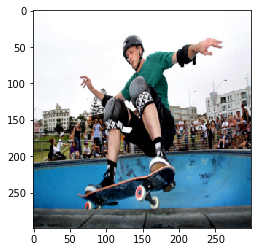

In [37]:
plt.imshow(img)

In [38]:
for i in range(10):    
    print(generate_caption(img, tokens, t=5.)[0].replace('BOS','').replace('EOS',''))
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


 a man riding a skateboard down a ramp . 
 a man riding a skateboard down a ramp . 
 a man riding a skateboard down a ramp . 
 a man riding a skateboard on a ramp . 
 a man riding a skateboard on a ramp . 
 a man is jumping a skateboard trick in the air . 
 a man riding a skateboard down a ramp . 
 a man riding a skateboard down a ramp . 
 a man riding a skateboard down a ramp . 
 a man riding a skateboard down a ramp . 


In [39]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg


--2020-02-23 18:04:09--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 104.239.249.248
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2020-02-23 18:04:09--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K  --.-KB/s    in 0.08s   

2020-02-23 18:04:09 (1.35 MB/s) - ‘img.jpg’ saved [106870/106870]



In [0]:
img = plt.imread('img.jpg')
img = resize(img, (299, 299)) #TTT

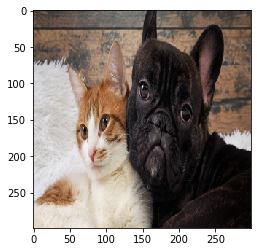

In [41]:
plt.imshow(img)

In [42]:
for i in range(10):    
    print(generate_caption(img, tokens, t=5.)[0].replace('BOS','').replace('EOS',''))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


 a dog is sitting on a couch with a cat . 
 a dog is sitting on a couch with a cat . 
 a cat is sitting on a chair in a room . 
 a dog is sitting on a couch with a cat . 
 a dog is sitting on a bed with a cat . 
 a dog is sitting on a couch with a cat . 
 a dog is sitting on a bed with a large stuffed animal . 
 a dog is laying on a couch with a cat on it . 
 a cat is sitting on a couch with a cat . 
 a cat is sitting on a couch with a cat on it . 


# Demo

ВОТ ЩАС БУИТ СМИШНО

Теперь ищите свои картинки, применяйте к ним сетку, смотрите че получится, реализовывайте вариативную часть =)

--2020-02-23 18:05:13--  https://cottagelife.com/wp-content/uploads/2019/10/Cottage-Life-Ontario-Northland-Train-1200x800.jpg
Resolving cottagelife.com (cottagelife.com)... 104.197.194.201
Connecting to cottagelife.com (cottagelife.com)|104.197.194.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252087 (246K) [image/jpeg]
Saving to: ‘img-3.jpg’

img-3.jpg           100%[===================>] 246.18K  --.-KB/s    in 0.06s   

2020-02-23 18:05:14 (4.25 MB/s) - ‘img-3.jpg’ saved [252087/252087]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


 a train is traveling down the tracks in the middle of the road . 
 a train traveling down tracks next to a forest . 
 a train is moving down the tracks in the station . 
 a train is traveling down the tracks near a forest . 
 a train traveling down tracks next to a train station . 
 a train is traveling down the tracks . 
 a train traveling down train tracks next to a forest . 
 a train is traveling down the tracks . 
 a train traveling down tracks next to a train station . 
 a train is moving down the tracks in the station . 


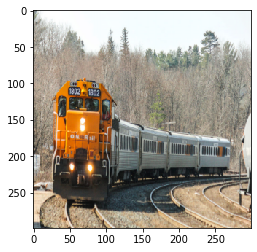

In [43]:
!wget https://cottagelife.com/wp-content/uploads/2019/10/Cottage-Life-Ontario-Northland-Train-1200x800.jpg -O img-3.jpg 
img = plt.imread('img-3.jpg')
img = resize(img, (299, 299)) #TTT
plt.imshow(img)
for i in range(10):    
    print(generate_caption(img, tokens, t=5.)[0].replace('BOS','').replace('EOS',''))

--2020-02-23 18:05:28--  https://mirnov.ru/images/photos/medium/article420503.jpg
Resolving mirnov.ru (mirnov.ru)... 80.93.187.215
Connecting to mirnov.ru (mirnov.ru)|80.93.187.215|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56533 (55K) [image/jpeg]
Saving to: ‘img-3.jpg’

img-3.jpg           100%[===================>]  55.21K  --.-KB/s    in 0.1s    

2020-02-23 18:05:29 (398 KB/s) - ‘img-3.jpg’ saved [56533/56533]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


 a group of birds sitting on a rock . 
 a group of birds standing on a rock . 
 a group of birds standing on top of a lush green field . 
 a group of birds standing on a rock . 
 a couple of birds standing on top of a grass covered field . 
 a group of birds standing on top of a rock . 
 a group of birds standing on top of a lush green field . 
 a group of birds standing on a rock . 
 a group of birds standing on a rock . 
 a small bird standing on a rock . 


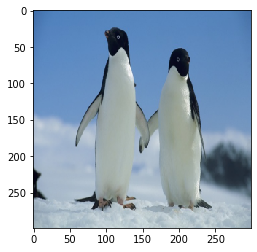

In [44]:
!wget https://mirnov.ru/images/photos/medium/article420503.jpg -O img-3.jpg 
img = plt.imread('img-3.jpg')
img = resize(img, (299, 299)) #TTT
plt.imshow(img)
for i in range(10):    
    print(generate_caption(img, tokens, t=5.)[0].replace('BOS','').replace('EOS',''))

--2020-02-23 18:06:42--  https://fermoved.ru/wp-content/uploads/2017/07/ponos-u-korovy-600x450.jpg
Resolving fermoved.ru (fermoved.ru)... 185.60.133.140
Connecting to fermoved.ru (fermoved.ru)|185.60.133.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70207 (69K) [image/jpeg]
Saving to: ‘img-7.jpg’

img-7.jpg           100%[===================>]  68.56K  --.-KB/s    in 0.1s    

2020-02-23 18:06:43 (465 KB/s) - ‘img-7.jpg’ saved [70207/70207]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


 a cow standing in a field of grass . 
 a cow standing in a field with a cow in the background . 
 a cow is standing in the grass near a fence . 
 a cow standing in a field with a cow in the background . 
 a cow standing in a field of grass . 
 a cow standing in a field with a cow in the background . 
 a cow standing in the grass next to a fence . 
 a cow standing in a grassy field with a cow in the background . 
 a cow standing in a field of grass . 
 a cow standing in a field of grass . 


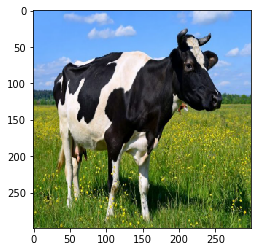

In [47]:
!wget https://fermoved.ru/wp-content/uploads/2017/07/ponos-u-korovy-600x450.jpg -O img-7.jpg 
img = plt.imread('img-7.jpg')
img = resize(img, (299, 299)) #TTT
plt.imshow(img)
for i in range(10):    
    print(generate_caption(img, tokens, t=5.)[0].replace('BOS','').replace('EOS',''))


--2020-02-23 18:06:54--  https://images.unian.net/photos/2020_01/1578592053-4230.jpg?0.33446115238377905
Resolving images.unian.net (images.unian.net)... 195.137.240.20, 195.137.240.21
Connecting to images.unian.net (images.unian.net)|195.137.240.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79085 (77K) [image/jpeg]
Saving to: ‘img-6.jpg’

img-6.jpg           100%[===================>]  77.23K  --.-KB/s    in 0.1s    

2020-02-23 18:06:55 (575 KB/s) - ‘img-6.jpg’ saved [79085/79085]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


 a man wearing a tie and a tie . 
 a man wearing a suit and tie with a tie . 
 a man wearing a tie and a suit and tie . 
 a man wearing a suit and tie holding a remote control . 
 a man wearing a tie and a tie . 
 a man wearing a suit and tie with a tie . 
 a man wearing a tie and tie with a hat . 
 a man wearing a tie and a tie . 
 a man wearing a suit and tie with a tie . 
 a man wearing a tie and a suit and tie . 


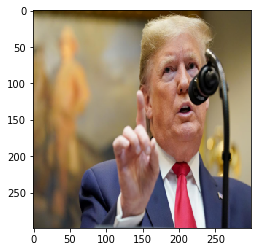

In [48]:
!wget https://images.unian.net/photos/2020_01/1578592053-4230.jpg?0.33446115238377905 -O img-6.jpg 
img = plt.imread('img-6.jpg')
img = resize(img, (299, 299)) #TTT
plt.imshow(img)
for i in range(10):    
    print(generate_caption(img, tokens, t=5.)[0].replace('BOS','').replace('EOS',''))

--2020-02-23 18:07:10--  https://www.cre.ru/content/upload/news/15528982809641.jpeg
Resolving www.cre.ru (www.cre.ru)... 195.211.102.149, 2a01:d8:4:5::10
Connecting to www.cre.ru (www.cre.ru)|195.211.102.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 195090 (191K) [image/jpeg]
Saving to: ‘img-8.jpg’

img-8.jpg           100%[===================>] 190.52K   266KB/s    in 0.7s    

2020-02-23 18:07:12 (266 KB/s) - ‘img-8.jpg’ saved [195090/195090]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


 a table with a plate of food on it . 
 a plate with a cup of coffee and a cup of coffee . 
 a table with a plate of food on it . 
 a plate with a cup of coffee and a cup of coffee . 
 a white plate with a cup of coffee and a cup of coffee . 
 a table with a plate of food and a cup of coffee 
 a white plate with a cup of coffee on it 
 a table with a plate of food on it 
 a plate with a cup of coffee and a cup of coffee 
 a table with a plate of food and a cup of coffee . 


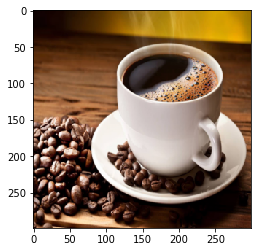

In [49]:
!wget https://www.cre.ru/content/upload/news/15528982809641.jpeg -O img-8.jpg 
img = plt.imread('img-8.jpg')
img = resize(img, (299, 299)) #TTT
plt.imshow(img)
for i in range(10):    
    print(generate_caption(img, tokens, t=5.)[0].replace('BOS','').replace('EOS',''))

--2020-02-23 18:07:30--  http://www.tadviser.ru/images/thumb/0/05/106121608-156812270546119c0753_02.jpg/840px-106121608-156812270546119c0753_02.jpg
Resolving www.tadviser.ru (www.tadviser.ru)... 185.159.81.170
Connecting to www.tadviser.ru (www.tadviser.ru)|185.159.81.170|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276850 (270K) [image/jpeg]
Saving to: ‘img-9.jpg’

img-9.jpg           100%[===================>] 270.36K   279KB/s    in 1.0s    

2020-02-23 18:07:31 (279 KB/s) - ‘img-9.jpg’ saved [276850/276850]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


 a large truck parked in front of a building . 
 a large truck driving down a road . 
 a large truck parked in a parking lot . 
 a large truck parked in front of a building . 
 a large truck parked in front of a building . 
 a large truck driving down a road . 
 a large truck parked in front of a building . 
 a large truck parked in front of a building . 
 a large truck parked in front of a building . 
 a large truck parked in front of a building . 


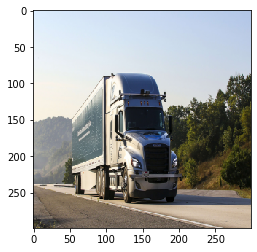

In [50]:
!wget http://www.tadviser.ru/images/thumb/0/05/106121608-156812270546119c0753_02.jpg/840px-106121608-156812270546119c0753_02.jpg -O img-9.jpg 
img = plt.imread('img-9.jpg')
img = resize(img, (299, 299)) #TTT
plt.imshow(img)
for i in range(10):    
    print(generate_caption(img, tokens, t=5.)[0].replace('BOS','').replace('EOS',''))

--2020-02-23 18:07:44--  https://img.povar.ru/main/7e/30/56/9b/kliukvennie_keksi-362669.jpg
Resolving img.povar.ru (img.povar.ru)... 116.202.35.146
Connecting to img.povar.ru (img.povar.ru)|116.202.35.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38977 (38K) [image/jpeg]
Saving to: ‘img-9.jpg’

img-9.jpg           100%[===================>]  38.06K  --.-KB/s    in 0s      

2020-02-23 18:07:45 (317 MB/s) - ‘img-9.jpg’ saved [38977/38977]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


 a table with a plate of food and a cup of coffee 
 a table with several plates of food on it . 
 a table with a plate of food and a cup of coffee . 
 a cake with a knife and a cup of coffee on it . 
 a table with a plate of food on it 
 a table with a bunch of donuts on it . 
 a cake with a knife and a fork on it . 
 a table with a plate of food and a cup of coffee 
 a cake with a knife and a fork on it . 
 a table with a plate of food and a cup of coffee 


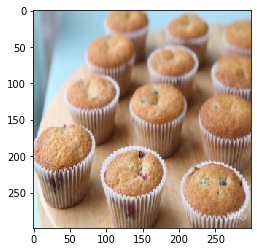

In [51]:
!wget https://img.povar.ru/main/7e/30/56/9b/kliukvennie_keksi-362669.jpg -O img-9.jpg 
img = plt.imread('img-9.jpg')
img = resize(img, (299, 299)) #TTT
plt.imshow(img)
for i in range(10):    
    print(generate_caption(img, tokens, t=5.)[0].replace('BOS','').replace('EOS',''))